# Criteo Uplift Modeling Dataset

This dataset is released along with the paper: “A Large Scale Benchmark for Uplift Modeling” Eustache Diemert, Artem Betlei, Christophe Renaudin; (Criteo AI Lab), Massih-Reza Amini (LIG, Grenoble INP) This work was published in: AdKDD 2018 Workshop, in conjunction with KDD 2018.

This dataset is constructed by assembling data resulting from several incrementality tests, a particular randomized trial procedure where a random part of the population is prevented from being targeted by advertising.

Here is a detailed description of the fields original dataset:

- **f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11**: feature values (dense, float)

- **treatment**: treatment group. Flag if a company participates in the RTB auction for a particular user (binary: 1 = treated, 0 = control)

- **exposure**: treatment effect, whether the user has been effectively exposed. Flag if a company wins in the RTB auction for the user (binary)

- **conversion**: whether a conversion occured for this user (binary, label)

- **visit**: whether a visit occured for this user (binary, label)

In [1]:
import sys

# install uplift library scikit-uplift and other libraries 
!{sys.executable} -m pip install scikit-uplift dill lightgbm

In [2]:
from sklift.datasets import fetch_criteo
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklift.models import TwoModels
import lightgbm as lgb
from sklift.metrics import qini_auc_score
from sklift.viz import plot_qini_curve

seed=31

## 📝 Load data

Dataset can be loaded from `sklift.datasets` module using `fetch_criteo` function. There are few function parameters:
- target_col – selects which column ('visit', 'conversion' or 'all') from dataset will be target
- treatment_col – selects which column ('treatment', 'exposure' or 'all') from dataset will be treatment.
- percent10 – whether to load only 10 percent of the data.

Let's load the dataset with default parameters (target = 'visit', treatment = 'treatment'). 

In [3]:
# returns sklearn Bunch object
# with data, target, treatment keys
# data features (pd.DataFrame), target (pd.Series), treatment (pd.Series) values 

dataset = fetch_criteo()

  0%|          | 0.00/311M [00:00<?, ?iB/s]

In [4]:
print(f"Dataset type: {type(dataset)}\n")
print(f"Dataset features shape: {dataset.data.shape}")
print(f"Dataset target shape: {dataset.target.shape}")
print(f"Dataset treatment shape: {dataset.treatment.shape}")

Dataset type: <class 'sklearn.utils.Bunch'>

Dataset features shape: (13979592, 12)
Dataset target shape: (13979592,)
Dataset treatment shape: (13979592,)


## 📝 EDA

Let's have a look at the data features.

In [5]:
dataset.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13979592 entries, 0 to 13979591
Data columns (total 12 columns):
 #   Column  Dtype  
---  ------  -----  
 0   f0      float64
 1   f1      float64
 2   f2      float64
 3   f3      float64
 4   f4      float64
 5   f5      float64
 6   f6      float64
 7   f7      float64
 8   f8      float64
 9   f9      float64
 10  f10     float64
 11  f11     float64
dtypes: float64(12)
memory usage: 1.2 GB


In [6]:
dataset.data.head().append(dataset.data.tail())

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679
13979587,26.297764,10.059654,9.006250,4.679882,10.280525,4.115453,-3.282109,4.833815,3.839578,13.190056,5.300375,-0.168679
13979588,12.642207,10.679513,8.214383,-1.700105,10.280525,3.013064,-13.955150,6.269026,3.971858,13.190056,5.300375,-0.168679
13979589,12.976557,10.059654,8.381868,0.842442,11.029584,4.115453,-8.281971,4.833815,3.779212,23.570168,6.169187,-0.168679
13979590,24.805064,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679
13979591,12.616365,10.059654,8.214383,4.679882,10.280525,3.013064,0.294443,9.332563,3.971858,13.190056,5.300375,-0.168679


In [7]:
dataset.data.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11
count,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07
mean,1.962030e+01,1.006998e+01,8.446582e+00,4.178923e+00,1.033884e+01,4.028513e+00,-4.155356e+00,5.101765e+00,3.933581e+00,1.602764e+01,5.333396e+00,-1.709672e-01
std,5.377464e+00,1.047557e-01,2.993161e-01,1.336645e+00,3.433081e-01,4.310974e-01,4.577914e+00,1.205248e+00,5.665958e-02,7.018975e+00,1.682288e-01,2.283277e-02
min,1.261636e+01,1.005965e+01,8.214383e+00,-8.398387e+00,1.028053e+01,-9.011892e+00,-3.142978e+01,4.833815e+00,3.635107e+00,1.319006e+01,5.300375e+00,-1.383941e+00
25%,1.261636e+01,1.005965e+01,8.214383e+00,4.679882e+00,1.028053e+01,4.115453e+00,-6.699321e+00,4.833815e+00,3.910792e+00,1.319006e+01,5.300375e+00,-1.686792e-01
50%,2.192341e+01,1.005965e+01,8.214383e+00,4.679882e+00,1.028053e+01,4.115453e+00,-2.411115e+00,4.833815e+00,3.971858e+00,1.319006e+01,5.300375e+00,-1.686792e-01
75%,2.443646e+01,1.005965e+01,8.723335e+00,4.679882e+00,1.028053e+01,4.115453e+00,2.944427e-01,4.833815e+00,3.971858e+00,1.319006e+01,5.300375e+00,-1.686792e-01
max,2.674526e+01,1.634419e+01,9.051962e+00,4.679882e+00,2.112351e+01,4.115453e+00,2.944427e-01,1.199840e+01,3.971858e+00,7.529502e+01,6.473917e+00,-1.686792e-01


In [8]:
print('Number NA:', dataset.data.isna().sum().sum())

Number NA: 0


Some notes:

- There are 12 columns in the dataset
- All feature values are float
- There are no missing values in data.

###  Target and treatment 

Also take a look at target and treatment.

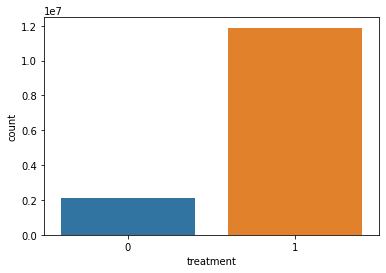

In [9]:
sns.countplot(x=dataset.treatment)

In [10]:
dataset.treatment.value_counts()

1    11882655
0     2096937
Name: treatment, dtype: Int64

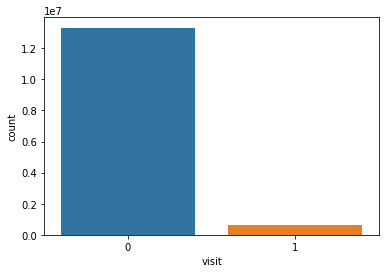

In [11]:
sns.countplot(x=dataset.target)

In [12]:
dataset.target.value_counts()

0    13322663
1      656929
Name: visit, dtype: Int64

In [13]:
pd.crosstab(dataset.treatment, dataset.target, normalize='index')

visit,0,1
treatment,,
0,0.961799,0.038201
1,0.951457,0.048543


Just note that the target and treatment groups are not balanced.

### Simple baseline

Optimizing the size of the dataset for low memory environment.

In [14]:
for c in dataset.data.columns:
    dataset.data[c] = pd.to_numeric(dataset.data[c], downcast='float')

In [15]:
dataset.treatment = dataset.treatment.astype('int8')
dataset.target = dataset.target.astype('int8')

In a binary classification problem definition we stratify train set by splitting target `0/1` column. In uplift modeling we have two columns instead of one. 

In [16]:
stratify_cols = pd.concat([dataset.treatment, dataset.target], axis=1)

X_train, X_val, trmnt_train, trmnt_val, y_train, y_val = train_test_split(
    dataset.data,
    dataset.treatment,
    dataset.target,
    stratify=stratify_cols,
    test_size=0.3,
    random_state=31
)

print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")

Train shape: (9785714, 12)
Validation shape: (4193878, 12)


In [17]:
treatment_model = lgb.LGBMClassifier(random_state=31)
control_model = lgb.LGBMClassifier(random_state=31)
tm = TwoModels(estimator_trmnt = treatment_model, estimator_ctrl = control_model, method='vanilla')


In [18]:
tm = tm.fit(X_train, y_train, trmnt_train)

In [19]:
uplift_tm = tm.predict(X_val)

In [20]:
# AUQC = area under Qini curve = Qini coefficient
auqc = qini_auc_score(y_val, uplift_tm, trmnt_val) 
print(f"Qini coefficient on full data: {auqc:.4f}")

Qini coefficient on full data: 0.0836


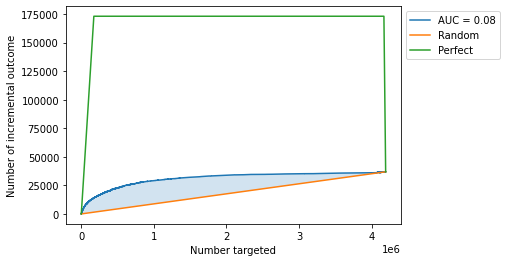

In [21]:
# with ideal Qini curve (red line)
# perfect=True

plot_qini_curve(y_val, uplift_tm, trmnt_val, perfect=True);